# HV Calibration

This notebook is a first attempt at performing calibration based on HV data. The calibration will be based on Matt's work [here (login required)](https://zzz.physics.umn.edu/!cdms/cdms/k100/run_summary/run_76#calibration_with_baseline_correction), rather than the previous, incorrect ladder calibration.

In [1]:
#Imports
import uproot
import glob
import math
import numpy as np
import pandas as pd
import datetime as dt
import lmfit as lf
import matplotlib.pyplot as plt
from matplotlib import cm
#%matplotlib inline

In [2]:
datapath = "RQData/"
ser = ["07220702_0911"]
lab = ["data"]

nser = len(ser); e=[]; z=[];
for s in range(nser):
    e_chain = pd.DataFrame(); z_chain = pd.DataFrame();
    for file in glob.glob(datapath+ser[s]+"/umn*root"):
        if e_chain.empty: #For first entry, generate columns
            e_chain = pd.concat([e_chain,uproot.open(file)["rqDir/eventTree"].pandas.df()],axis=1)
            z_chain = pd.concat([z_chain,uproot.open(file)["rqDir/zip1"].pandas.df()],axis=1)
        else:
            e_chain = pd.concat([e_chain,uproot.open(file)["rqDir/eventTree"].pandas.df()],ignore_index=True)
            z_chain = pd.concat([z_chain,uproot.open(file)["rqDir/zip1"].pandas.df()],ignore_index=True)
    e.append(e_chain); z.append(z_chain)
    
for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)

print(list(z[0])) #really just verifying that I imported something

#extra simplifying code since we have only one series
z = z[0]
e = e[0]

['DetType', 'Empty', 'PAINTall', 'PAOFamps', 'PAOFamps0', 'PAOFchisq', 'PAOFchisqLF', 'PAOFdelay', 'PATFPamp', 'PATFPchisq', 'PATFPeflag', 'PATFPint', 'PATFPoffset', 'PATFPtau', 'PAWKf20', 'PAWKf40', 'PAWKf80', 'PAWKf90', 'PAWKf95', 'PAWKmax', 'PAWKr10', 'PAWKr100', 'PAWKr20', 'PAWKr30', 'PAWKr40', 'PAWKr50', 'PAWKr60', 'PAWKr70', 'PAWKr80', 'PAWKr90', 'PAWKr95', 'PAbias', 'PAbs', 'PAbspost', 'PAgain', 'PAnorm', 'PAsat', 'PAstd', 'PBINTall', 'PBOFamps', 'PBOFamps0', 'PBOFchisq', 'PBOFchisqLF', 'PBOFdelay', 'PBTFPamp', 'PBTFPchisq', 'PBTFPeflag', 'PBTFPint', 'PBTFPoffset', 'PBTFPtau', 'PBWKf20', 'PBWKf40', 'PBWKf80', 'PBWKf90', 'PBWKf95', 'PBWKmax', 'PBWKr10', 'PBWKr100', 'PBWKr20', 'PBWKr30', 'PBWKr40', 'PBWKr50', 'PBWKr60', 'PBWKr70', 'PBWKr80', 'PBWKr90', 'PBWKr95', 'PBbias', 'PBbs', 'PBbspost', 'PBgain', 'PBnorm', 'PBsat', 'PBstd', 'PCINTall', 'PCOFamps', 'PCOFamps0', 'PCOFchisq', 'PCOFchisqLF', 'PCOFdelay', 'PCTFPamp', 'PCTFPchisq', 'PCTFPeflag', 'PCTFPint', 'PCTFPoffset', 'PCTFPta

In [5]:
crand = np.array([(x==1) for x in z['EventCategory']])
z['PTwid'] = (z['PTWKf40'] - z['PTWKr40'])*1e6
z['PTdbs'] = (z['PAbspost'] - z['PAbs'] + z['PBbspost'] - z['PBbs'] 
    + z['PCbspost'] - z['PCbs'] + z['PDbspost'] - z['PDbs'] + z['PEbspost'] - z['PEbs']
    + z['PFbspost'] - z['PFbs'])
z['PTINTall_PTbscorr'] = z['PTINTall'] - ((z['PTdbs']<0)*0.5*z['PTdbs']*4096/z['PFnorm'])

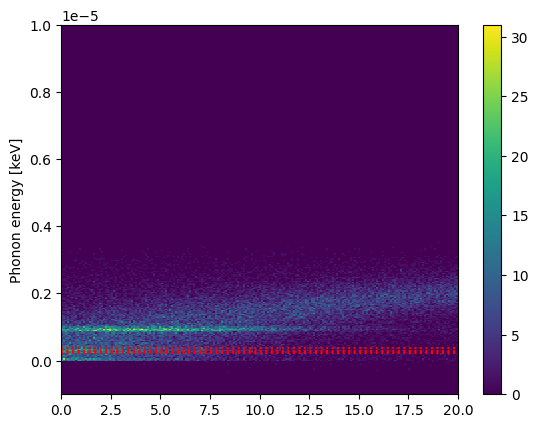

In [68]:
fig = plt.figure()
h = plt.hist2d(z["PTdbs"][~crand],z["PTOFamps"][~crand]
               ,bins=[np.linspace(0,20,200),np.linspace(-1e-6,1e-5,300)])
plt.ylabel("Phonon energy [keV]")
#plt.xlabel("Baseline elevation") #Not true yet; just the goal. 
#Based on the calculation I think this might be what I have now? But,
#Based on the plot it's very clearly not it.
fig.colorbar(h[3])

pointsx = [0,0.22e-6,0.29e-6,0.38e-6] #Measured outputs, not yet known.

plt.axhline(pointsx[1],color='red',linestyle='dotted')
plt.axhline(pointsx[2],color='red',linestyle='dotted')
plt.axhline(pointsx[3],color='red',linestyle='dotted')

plt.show()

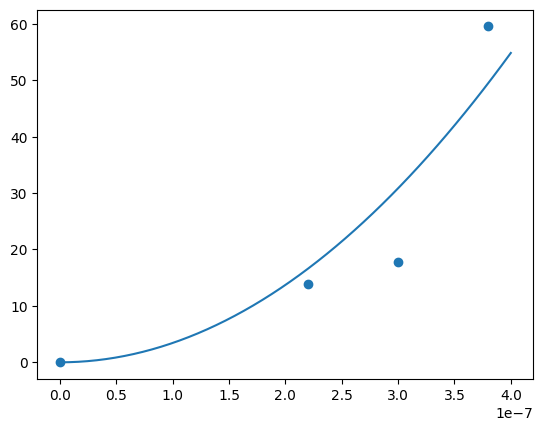

In [62]:
pointsx = [0,0.22e-6,0.3e-6,0.38e-6] #Measured outputs, not yet known.
pointsy = [0,13.95,17.74,59.54] #Americium lines expected points
gcal = [pointsx,pointsy]; del pointsx,pointsy

def cal(x,a=1,b=1):
    return a*x+b*x**2

calmod = lf.Model(cal)
calparams = calmod.make_params()
calparams.add('a',value=gcal[1][-1]/gcal[0][-1],min=0)
calparams.add('b',value=gcal[1][-1]/gcal[0][-1],min=0)
calfit = calmod.fit(gcal[1],calparams,x=gcal[0])

plotx = np.linspace(0,4e-7,50)
plt.plot(plotx,cal(plotx,calfit.best_values['a'],calfit.best_values['b']))
plt.scatter(gcal[0],gcal[1])

plt.show()

calfit